# Gill_HW3

This homework assignment presents a simple data model for airport simulation using DES. Flyers who have an outgoing flight will go through the departure process at DTW airport before boarding their respective flights. 

NOTE: Flyer arrivals in this assignment is NOT referring to passengers arriving from another airport to DTW and then leaving the airport. Rather, passengers show up at airport and are expected to go through the process of checking-in with airline, adding any checked-bags, going through a TSA security check, finding their respective gate, and boarding the flight

## Preliminaries

In [92]:
# To auto-reload modules in jupyter notebook (so that changes in files *.py doesn't require manual reloading):
# https://stackoverflow.com/questions/5364050/reloading-submodules-in-ipython
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Import commonly used libraries and magic command for inline plotting

In [93]:
import math
import numpy as np
import pandas as pd
from scipy import optimize
import matplotlib.pyplot as plt
import seaborn as sns
from numpy.random import default_rng
from IPython.display import Image
import simpy

In [94]:
%matplotlib inline

## SimPy Model 1: Create a flyer departure generator

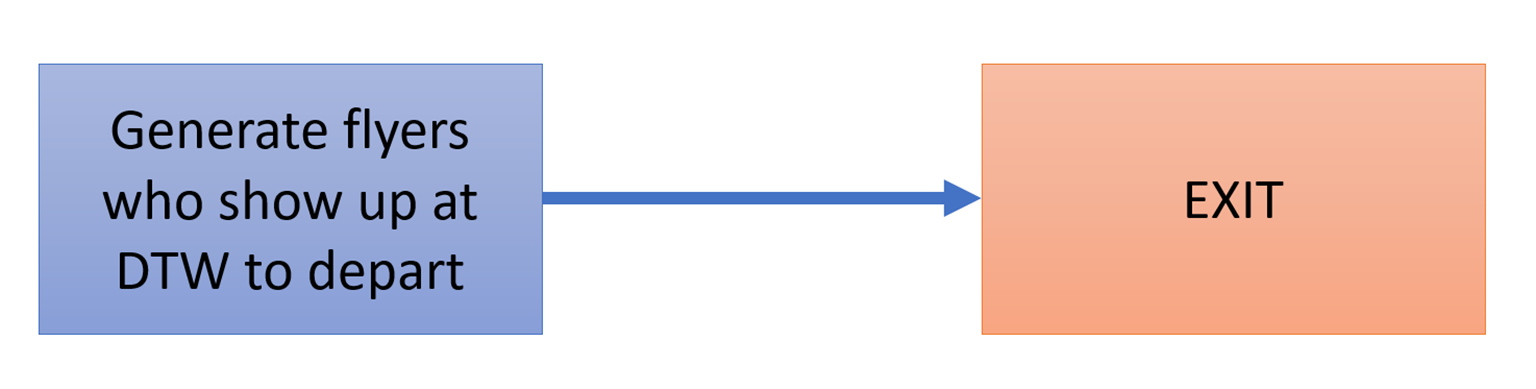

In my function, I take in two parameters: the simulation environment(env) and the interarrival_time which will have flyers show up every minute with a default of 5.0

In [95]:
def flyer_arrivals(env, interarrival_time=5.0):
    """Gnereate flyers according to a fixed time arrival process"""
    
    # Make a counter to keep track of flyers entering airport (uniqueID)
    flyer = 0
    
    # We want to keep generating flyers, so an infinite* loop is used
    while True:
        # Create next interarrival time
        next_time = interarrival_time
        
        # Yield a timeout event and resume after next_time units
        yield env.timeout(next_time)
        
        # Every time a new flyer enters the airport, we want to update our flyer variable
        flyer += 1
        
        print(f"Flyer {flyer} created at time {env.now}")

Create a simple simulation model that generates flyers for a fixed interval of time.

In [96]:
# Initialize a new environment
env1 = simpy.Environment()

# Create generator and add flyer to environment for equally-spaced interarrival_time values
runtime = 33
interarrival_time = 3.0
flyer_generator = flyer_arrivals(env1, interarrival_time)
env1.process(flyer_generator)

# Run simulation
env1.run(until=runtime)

Flyer 1 created at time 3.0
Flyer 2 created at time 6.0
Flyer 3 created at time 9.0
Flyer 4 created at time 12.0
Flyer 5 created at time 15.0
Flyer 6 created at time 18.0
Flyer 7 created at time 21.0
Flyer 8 created at time 24.0
Flyer 9 created at time 27.0
Flyer 10 created at time 30.0


 Since not everyone who shows up at an airport arrives in equally-spaced time intervals. Thus, we will use a Poisson arrival process to generate random intervals. 

In [97]:
from numpy.random import default_rng
rg = default_rng(seed=2468)
print(rg.random())
print(rg.random())

0.4152638067771849
0.6286949390827768


Create a histogram the visually present the times of arrivals at DTW by flyers wanting to depart.

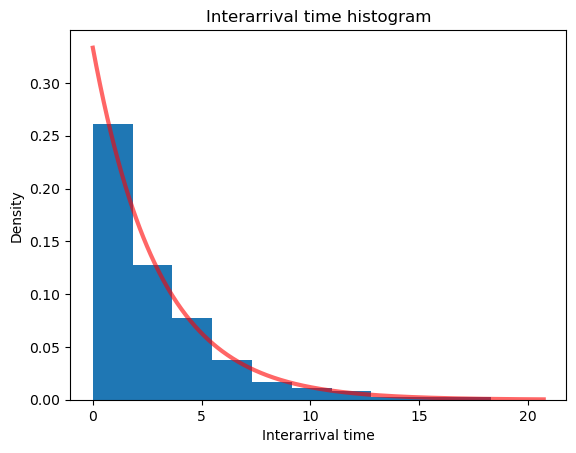

In [98]:
from scipy.stats import expon
# Set mean of distrubution to interarrival_time
mean_interarrival_time = interarrival_time

# Make a random variable object based on distribution above
rv_expon = expon(scale=mean_interarrival_time)

# Create 1000 exponential random variates using numpy
time_sample = rg.exponential(mean_interarrival_time, 1000)

# Make a histogram of the sample
plt.title("Interarrival time histogram")
plt.xlabel("Interarrival time")
plt.ylabel("Density")
plt.hist(time_sample, density=True);

# Make values for x-axis
x_expon = np.linspace(rv_expon.ppf(0.0001),
                      rv_expon.ppf(0.999), 500)

# Create values for y-axis
y_expon_pdf = rv_expon.pdf(x_expon)

plt.plot(x_expon, y_expon_pdf, 'r-', lw=3, alpha=0.6, label='Exponential PDF');

Modify our flyer arrivals function to use Posson arrivals.

In [99]:
def flyer_arrivals_random_1(env, mean_interarrival_time=5.0, rg=default_rng(0)):
    """Create flyers entering DTW under a Posson arrival process"""
    
    # Create a counter to keep track of number of flyers generated (uniqueID)
    flyer = 0 
    
    # As before, we will create an infinite* loop 
    while True:
        # Create next interarrival time from exponential distribution
        next_time = rg.exponential(mean_interarrival_time)
        
        # Yield a timeout event and resume after next_time units
        yield env.timeout(next_time)
        
        # Every time a new flyer enters the airport, we want to update our flyer variable
        flyer += 1
        
        print(f"Flyer {flyer} created at time {env.now}")

Create a new simulation environment and run the new arrival model, so that arrivals are not equally spaced.

In [100]:
# Initialize a simulation environment
env2 = simpy.Environment()

# Create a process generator and add it to the 'env', and use env.process()
runtime = 35
interarrival_time = 3.0
env2.process(flyer_arrivals_random_1(env2, interarrival_time))

# Run the simulation
env2.run(until=runtime)

Flyer 1 created at time 2.039795711906729
Flyer 2 created at time 5.098587016304323
Flyer 3 created at time 5.158007004071489
Flyer 4 created at time 5.164814984115174
Flyer 5 created at time 6.815843602032318
Flyer 6 created at time 11.705664906007474
Flyer 7 created at time 13.72641376400917
Flyer 8 created at time 15.992317837485343
Flyer 9 created at time 24.44267577471252


## SimPy Model 2: Airport simulation with delay processes

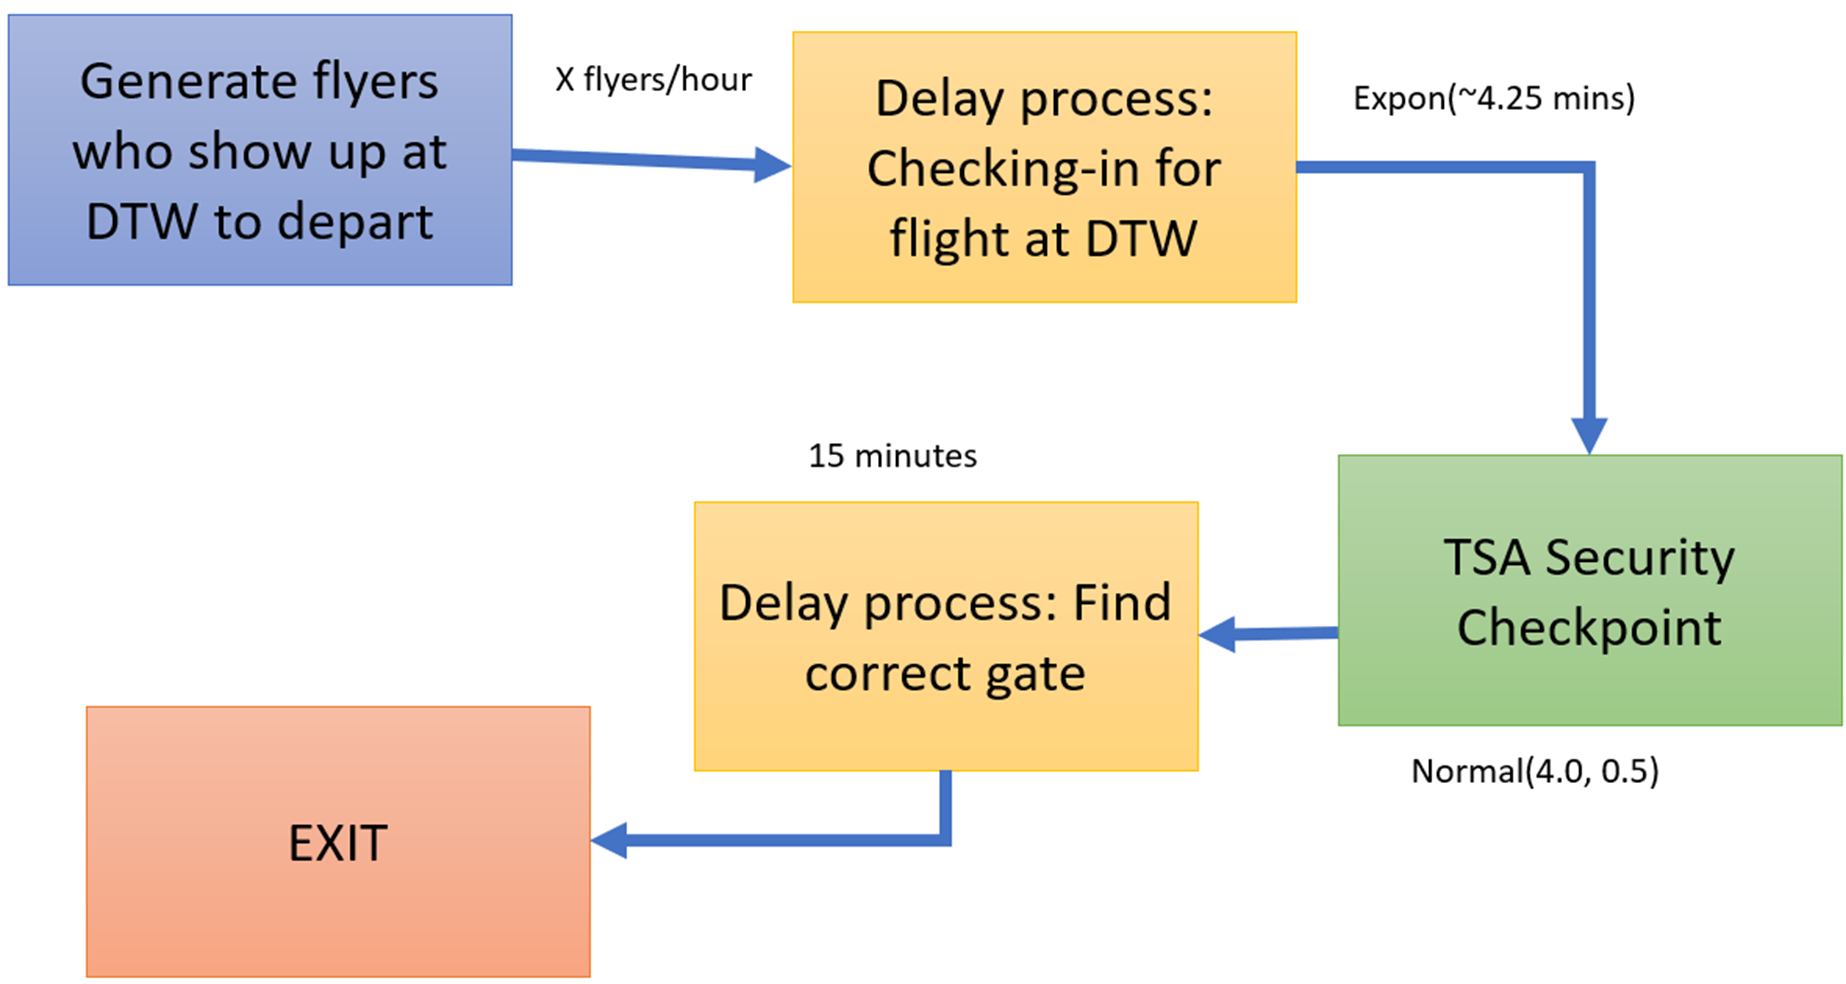

### Goal for model 2:
* Add a security-checkpoint resource
* Create a new process function for the new delays (check-in and finding gate)
* Modiify the process to create a TSA Security event for each flyer

In [101]:
def simplified_airport_process(env, name, mean_checkin_time, 
                               mean_tsa_time, mean_gate_time, check):
    """Process function modeling how a flyer goes through TSA checkpoint"""
    
    print(f"{name} entering DTW airport at {env.now:.4f}")
    
    # Yield for the checking-in time (first delay)
    yield env.timeout(rg.exponential(mean_checkin_time))
    
    # Request/Provide TSA agent with your information to go through checkpoint
    with check.request() as request:
        print(f"{name} provided information to TSA agent at {env.now:.4f}")
        yield request
        print(f"{name} left TSA checkpoint {env.now:.4f}")
        yield env.timeout(rg.normal(mean_tsa_time, 0.5))
        
    # Yield for the finding-gate time (another delay)
    yield env.timeout(mean_gate_time)
    
    # Process is complete and you can exit DTW airport
    print(f"{name} exiting DTW airport at {env.now:.4f}")

In [102]:
def flyer_arrivals_random_2(env, mean_interarrival_time, mean_checkin_time, mean_tsa_time,
                           mean_gate_time, check, rg=default_rng(0)):
    """Generate flyers in a Poisson process"""
    
    # Create a counter to track number of flyers (uniqueID)
    flyer = 0
    
    # As before, we will create an infinite* loop 
    while True:
        
        # Generate next interarrival time
        next_time = rg.exponential(mean_interarrival_time)
               
        # Yield a timeout event and resume after next_time units
        yield env.timeout(next_time)
        
        # Every time a new flyer enters the airport, we want to update our flyer variable
        flyer += 1
        
        print(f"Flyer {flyer} created at time {env.now}")
        
        # Make a new flyer delay process generator object
        flyer_visit = simplified_airport_process(env, 'Flyer {}'.format(flyer),
                                                mean_checkin_time, mean_tsa_time, 
                                                mean_gate_time, check)
        
        # Register the new process with the simulation environment
        env.process(flyer_visit)

In [103]:
# Run the new model

# Initialize a simulation environment
env3 = simpy.Environment()

# Assign inputs
mean_interarrival_time = 3.0
mean_checkin_time = 4.25
mean_tsa_time = 4.0
mean_gate_time = 15.0
num_checks = 2

# Create the security-checkpoint resource
check = simpy.Resource(env3, num_checks)

# Register the new arrivals process in one step, unlike above which was two steps
env3.process(flyer_arrivals_random_2(env3, mean_interarrival_time, mean_checkin_time,
                                    mean_tsa_time, mean_gate_time, check))

# Run the simulation
runtime = 50
env3.run(until=runtime)

Flyer 1 created at time 2.039795711906729
Flyer 1 entering DTW airport at 2.0398
Flyer 1 provided information to TSA agent at 2.5269
Flyer 1 left TSA checkpoint 2.5269
Flyer 2 created at time 5.098587016304323
Flyer 2 entering DTW airport at 5.0986
Flyer 3 created at time 5.158007004071489
Flyer 3 entering DTW airport at 5.1580
Flyer 4 created at time 5.164814984115174
Flyer 4 entering DTW airport at 5.1648
Flyer 5 created at time 6.815843602032318
Flyer 5 entering DTW airport at 6.8158
Flyer 4 provided information to TSA agent at 7.1169
Flyer 4 left TSA checkpoint 7.1169
Flyer 5 provided information to TSA agent at 7.2774
Flyer 5 left TSA checkpoint 7.2774
Flyer 2 provided information to TSA agent at 7.6209
Flyer 3 provided information to TSA agent at 10.6852
Flyer 2 left TSA checkpoint 11.4983
Flyer 6 created at time 11.705664906007474
Flyer 6 entering DTW airport at 11.7057
Flyer 3 left TSA checkpoint 11.8880
Flyer 6 provided information to TSA agent at 12.1742
Flyer 7 created at ti

## SimPy Model 3: Full Airport Simulation

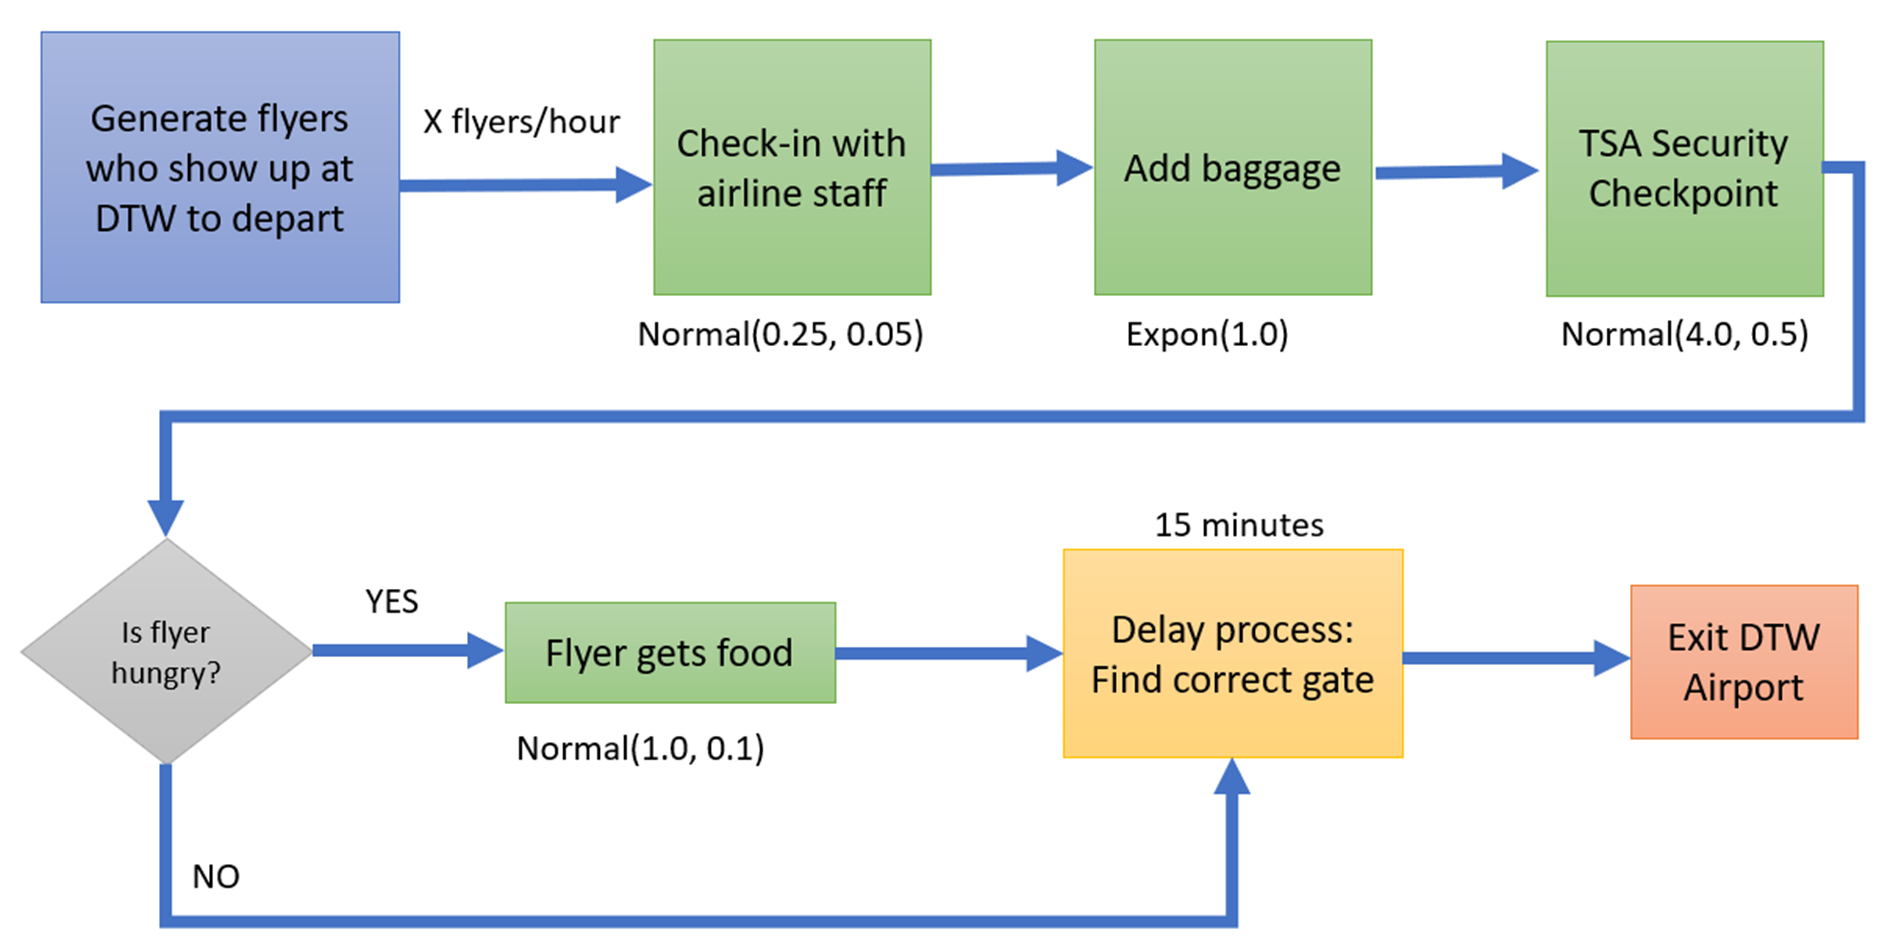

For this last model, we need to create a class called AirportSim which will have:
* SimPy environment
* Resource capacity related inputs
* Data structures to store data collected for flyers throughout simulation
* SimPy resources for modeling the various types of airport staff modeled
* Process methods corresponding to processing times in each state of the simulation

In [104]:
class AirportSim(object):
    def __init__(self, env, num_checkin_staff, num_bags, num_checks,
                num_food_staff, rg):
        #Simulation environment
        self.env = env
        self.rg = rg
        
        # Create a list to hold each timestamp for our flyer (dictionaries)
        self.timestamps_list = []
        # Initialize lists to hold occupancy tuples for the stages in the simulation (at time XYZ, occupancy)
        self.baggage_occupancy_list = [(0.0, 0.0)]
       
        # Create resources
        self.airline_check = simpy.Resource(env, num_checkin_staff)
        self.baggage_check = simpy.Resource(env, num_bags)
        self.check = simpy.Resource(env, num_checks)
        self.food_check = simpy.Resource(env, num_food_staff)
        
    # Generate process methods - the flyer argument is a uniqueID
    def checkin_airline(self, flyer):
        yield self.env.timeout(self.rg.normal(0.25, 0.05))
        
    def checkin_baggage(self, flyer):
        yield self.env.timeout(self.rg.exponential(1.0))
        
    def checkin_tsa(self, flyer):
        yield self.env.timeout(self.rg.normal(4.0, 0.5))
        
    def checkin_food(self, flyer):
        yield self.env.timeout(self.rg.normal(1.0, 0.25))
        
        
    # Assume all passengers take at least 15 minutes to find the correct gate
    def wait_gt_15(self, flyer):
        yield self.env.timeout(self.rg.exponential(0.5))
    

Create a depart_airport function to detail the sequence of steps taken by flyers, which includes:
* Simulation environment
* Flyer identifier
* An airport object derived from the AirportSim class
* The percenteage of flyers that are NOT hungry after TSA checkpoint 
* A random number generator (see past two models)

In [105]:
def depart_airport(env, flyer, airport, pct_not_hungry, rg):
    # Flyer arrives at DTW
    arrival_ts = env.now
    
    # Request airline staff for checking into flight
    with airport.airline_check.request() as request:
        yield request
        # Get the timestamps
        enter_checkin_ts = env.now
        yield env.process(airport.checkin_airline(flyer))
        exit_checkin_ts = env.now
        
    # Request airline staff for checking baggage
    with airport.baggage_check.request() as request:
        yield request
        # Get the timestamps
        enter_bags_ts = env.now
        # Update baggage occupancy by 1
        prev_occ = airport.baggage_occupancy_list[-1][1]
        new_occ = (env.now, prev_occ + 1)
        airport.baggage_occupancy_list.append(new_occ)
        yield env.process(airport.checkin_baggage(flyer))
        exit_bags_ts = env.now
        airport.baggage_occupancy_list.append(
            (env.now, airport.baggage_occupancy_list[-1][1] - 1))
        
   # Request/Provide TSA agent with your information to go through checkpoint
    with airport.check.request() as request:
        yield request
        # Get the timestamps
        enter_tsa_ts = env.now        
        yield env.process(airport.checkin_tsa(flyer))
        exit_tsa_ts = env.now
        
    # Check percentage of hungry flyers
    if rg.random() < pct_not_hungry:
        with airport.food_check.request() as request:
            yield request
            # Get the timestamps
            enter_food_ts = env.now
            yield env.process(airport.checkin_food(flyer))
            exit_food_ts = env.now
    else:
        enter_food_ts = pd.NA
        exit_food_ts = pd.NA
    
    # Take 15 minutes to find gate
    post_tsa_time = env.now - exit_tsa_ts
    if post_tsa_time < 15:
        # Take time to find gate
        yield env.timeout(15 - post_tsa_time)
        # Wait random amount beyond 15 minutes
        yield env.process(airport.wait_gt_15(flyer))
        exit_airport_ts = env.now

    exit_airport_ts = env.now
#     print(f"Flyer {flyer} boarded flight at TIME {env.now}")

    # Create dictionary of timestamps
    timestamps = {
        'flyer_id': flyer,
        'arrival_ts': arrival_ts,
        'enter_checkin_ts': enter_checkin_ts,
        'exit_checkin_ts': exit_checkin_ts,
        'enter_bags_ts': enter_bags_ts,
        'exit_bags_ts': exit_bags_ts,
        'enter_tsa_ts': enter_tsa_ts,
        'exit_tsa_ts': exit_tsa_ts,
        'enter_food_ts': enter_food_ts,
        'exit_food_ts': exit_food_ts,
        'exit_airport': exit_airport_ts
    }
    
    airport.timestamps_list.append(timestamps)

Add a run_airport function that will take in:
* Simulation environment
* Airport object
* Mean flyer interarrival time
* Percentage of flyers that are NOT hungry
* Random number generator
* Stopping conditions for simulations with stop time or max number of arrivals

In [106]:
def run_airport(env, airport, mean_interarrival_time, pct_not_hungry, rg,
               stoptime=simpy.core.Infinity, max_arrivals=simpy.core.Infinity):
    # Generate a tracker of flyers
    flyer = 0
    
    # Go through flyers loop
    while env.now < stoptime and flyer < max_arrivals:
        
        # Generate next interarrival time
        next_time = rg.exponential(mean_interarrival_time)
               
        # Yield a timeout event and resume after next_time units
        yield env.timeout(next_time)
        
        # Every time a new flyer enters the airport, we want to update our flyer variable
        flyer += 1
        
        env.process(depart_airport(env, flyer, airport, pct_not_hungry, rg))

Create a main() function that will act as entry point to using simulation.

In [107]:
def main():
    # For now, we will hard code the arrival rate (flyers per hour)
    flyers_per_hour = 10
    mean_interarrival_time = 1.0 / (flyers_per_hour / 60.0)
    pct_not_hungry = 0.50
    
    # Random number generator
    rg = default_rng(seed=3000)
    
    # Hard code resource capacity levels
    num_checkin_staff = 5
    num_bags = 5
    num_checks = 10
    num_food_staff = 5
    
    # Hours of operation, below we hardcoded the cutoff time
    stoptime = 700
    
    # Create a simulation environment
    env = simpy.Environment()
    # Create an airport
    airport = AirportSim(env, num_checkin_staff, num_bags, num_checks,
                        num_food_staff, rg)
    
    # Register the run_airport function
    env.process(run_airport(env, airport, mean_interarrival_time,
                           pct_not_hungry, rg, stoptime=stoptime))
    
    # Run the simulation
    env.run()
    
    # Output log files
    flyer_log_df = pd.DataFrame(airport.timestamps_list) # Our timestamps
    flyer_log_df.to_csv('./output/flyer_log_df.csv', index=False)
    
    flyer_baggage_occupancy_df = pd.DataFrame(airport.baggage_occupancy_list) # Our baggage stage occupancy list
    flyer_baggage_occupancy_df.to_csv('./output/flyer_baggage_occupancy_df.csv', index=False)
    
    # Simulation is over
    end_time = env.now
    print(f"Airport simulation ended at time {end_time}")

In [108]:
# Run everything with main()
airport_end_time = main()

flyer_log_df = pd.read_csv('./output/flyer_log_df.csv')
flyer_log_df.info()
flyer_log_df.head()

Airport simulation ended at time 732.6126011084087
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 115 entries, 0 to 114
Data columns (total 11 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   flyer_id          115 non-null    int64  
 1   arrival_ts        115 non-null    float64
 2   enter_checkin_ts  115 non-null    float64
 3   exit_checkin_ts   115 non-null    float64
 4   enter_bags_ts     115 non-null    float64
 5   exit_bags_ts      115 non-null    float64
 6   enter_tsa_ts      115 non-null    float64
 7   exit_tsa_ts       115 non-null    float64
 8   enter_food_ts     74 non-null     float64
 9   exit_food_ts      74 non-null     float64
 10  exit_airport      115 non-null    float64
dtypes: float64(10), int64(1)
memory usage: 10.0 KB


,flyer_id,arrival_ts,enter_checkin_ts,exit_checkin_ts,enter_bags_ts,exit_bags_ts,enter_tsa_ts,exit_tsa_ts,enter_food_ts,exit_food_ts,exit_airport
0,1,7.274546,7.274546,7.495075,7.495075,8.397220,8.397220,12.028997,NaN,NaN,27.031818
1,2,9.979096,9.979096,10.199393,10.199393,12.112745,12.112745,16.347323,16.347323,17.712960,32.298441
2,3,11.798109,11.798109,12.017528,12.017528,13.713364,13.713364,17.870731,17.870731,18.348663,33.424902
3,5,17.652832,17.652832,17.950990,17.950990,18.479994,18.479994,22.238003,NaN,NaN,38.005845
4,4,17.342573,17.342573,17.591995,17.591995,18.656582,18.656582,23.456804,23.456804,24.673607,38.609954


In [109]:
# Find the difference between timestamps to calculate the duration
def compute_durations(timestamp_df):
    timestamp_df['wait_for_airline_checkin'] = timestamp_df.loc[:, 'enter_checkin_ts'] - timestamp_df.loc[:, 'arrival_ts']
    timestamp_df['wait_for_bag'] = timestamp_df.loc[:, 'enter_bags_ts'] - timestamp_df.loc[:, 'exit_checkin_ts']
    timestamp_df['wait_for_tsa'] = timestamp_df.loc[:, 'enter_tsa_ts'] - timestamp_df.loc[:, 'exit_bags_ts']
    timestamp_df['wait_for_food'] = timestamp_df.loc[:, 'enter_food_ts'] - timestamp_df.loc[:, 'exit_tsa_ts']
    timestamp_df['time_in_system'] = timestamp_df.loc[:, 'exit_airport'] - timestamp_df.loc[:, 'arrival_ts']
    
    return timestamp_df

,0,1


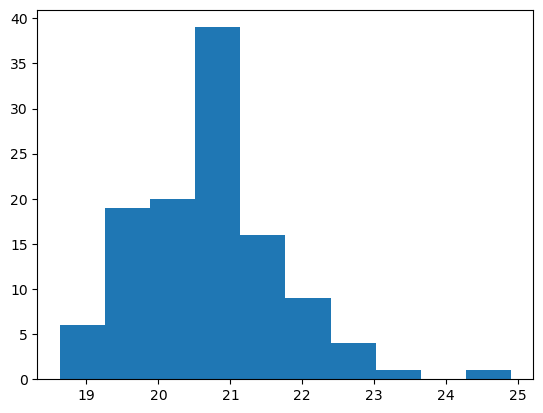

In [111]:
flyer_log_df = compute_durations(flyer_log_df)

# Create a histogram of wait times
plt.hist(flyer_log_df['time_in_system']);

# y = flyer_log_df['time_in_system'].rolling(100,10).mean()
# plt.plot(y)